<a href="https://colab.research.google.com/github/life-shaver/mohinhtaosinhanhvavideo/blob/lab01/Self_learning_exercises_20241018_smallCNN_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Bài thực hành với self-supervised learning
Đây là bài thực hành và ví dụ đối với tác vụ self-supervising learning với pretext task là việc xoay ảnh 4 góc cũng như tác vụ downstream task là việc phân loại ảnh. CSDL được sử dụng là CIAR-10.

Yêu cầu đối với bài thực hành này  gồm:

1. Thực hiện chạy các bước khi áp dụng self-supervised learning để huấn luyện
encoder bằng pretext task --> Sử dụng pretrained encoder để huấn luyện downstream task --> Đánh giá kết quả mô hình huấn luyện
2. Thực hiện một số tác vụ bổ sung. Trước hết, huấn luyện một mô hình phân loại (cùng cấu trúc) không sử dụng self-supervised và so sánh kết quả khi so với mô hình có áp dụng self-supervised trước đó (Bước 6)
3. Hiển thị ngẫu nhiên kết quả phân loại 10 ảnh trong CSDL ảnh CIFAR. Yêu cầu thực hiện lấy ngẫu nhiên theo seed = 42 (khi dùng hàm torch.manual_seed và numpy.manual_seed) (Bước 7 và 8)
4. Tăng số epoch lên 20, 30,... và đánh giá lại kết quả phân loại qua báo cáo
5. Thử thay thế SmallCNN Encoder trong ví dụ mẫu bằng một (vài) mô hình khác (như Resnet18, MobileNetV2, EfficientNet-B0, ....) cho bài toán phân loại đã thực hiện. Viết báo cáo đánh giá kết quả thực hiện bài toán phân loại CSDL CIFAR10 với những mô hình này (có và không sử dụng self-supervised)

Lưu ý: Với yêu cầu số 5, thời gian huấn luyện self-supervised với pretext task có thể sẽ lâu



**Bước 1: Định nghĩa SmallCNN Encoder và Pretext Task Model**



In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import random
import torch.cuda.amp as amp  # For mixed precision training

# Tối ưu hóa cuDNN cho hiệu suất tốt hơn
torch.backends.cudnn.benchmark = True

# Define rotation transformation
class RotationTransform:
    """Rotate an image by one of the given angles."""
    def __init__(self, angles=[0, 90, 180, 270]):
        self.angles = angles

    def __call__(self, x):
        angle = random.choice(self.angles)
        return transforms.functional.rotate(x, angle), self.angles.index(angle)

# Define a simple SmallCNN encoder
class SmallCNNEncoder(nn.Module):
    def __init__(self):
        super(SmallCNNEncoder, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1, 1))  # Pool to 1x1 output for each channel
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)  # Flatten the output
        return x

# Define the pretext task model for rotation prediction
class RotationPredictionModel(nn.Module):
    def __init__(self, encoder):
        super(RotationPredictionModel, self).__init__()
        self.encoder = encoder
        self.fc = nn.Linear(256, 4)  # 256 is the output size of SmallCNN, 4 classes for rotation (0°, 90°, 180°, 270°)

    def forward(self, x):
        features = self.encoder(x)
        out = self.fc(features)
        return out


**Bước 2: Chuẩn bị dữ liệu với CIFAR-10**

In [ ]:
# Load CIFAR-10 dataset with rotation transformation
transform = transforms.Compose([
    transforms.Resize(32),  # CIFAR-10 images are 32x32
    transforms.ToTensor()
])

rotation_transform = RotationTransform()

# Load dataset with rotation
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

# Apply rotation transformation
class RotationDataset(torch.utils.data.Dataset):
    def __init__(self, base_dataset, rotation_transform):
        self.base_dataset = base_dataset
        self.rotation_transform = rotation_transform

    def __getitem__(self, index):
        img, _ = self.base_dataset[index]
        rotated_img, rotation_label = self.rotation_transform(img)
        return rotated_img, rotation_label

    def __len__(self):
        return len(self.base_dataset)

rotation_train_dataset = RotationDataset(train_dataset, rotation_transform)
rotation_train_loader = DataLoader(rotation_train_dataset, batch_size=256, shuffle=True, num_workers=4, pin_memory=True)


100%|██████████| 170M/170M [00:04<00:00, 41.2MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


**Bước 3: Huấn luyện Pretext Task với SmallCNN**

Hãy kiên nhẫn vì thời gian huấn luyện mỗi epoch có thể sẽ khá lâu


In [ ]:
# Initialize the SmallCNN encoder and pretext task model
encoder = SmallCNNEncoder()
rotation_model = RotationPredictionModel(encoder)
rotation_model = rotation_model.cuda()

# Define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(rotation_model.parameters(), lr=0.001)

# Train the rotation prediction model using mixed precision for faster training
scaler = amp.GradScaler()  # For mixed precision training

def train_rotation_model(model, dataloader, criterion, optimizer, scaler, epochs=10):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for images, labels in dataloader:
            images, labels = images.cuda(), labels.cuda()
            with amp.autocast():  # Enable mixed precision
                outputs = model(images)
                loss = criterion(outputs, labels)

            optimizer.zero_grad()
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            total_loss += loss.item()

        print(f'Epoch [{epoch+1}/{epochs}], Loss: {total_loss/len(dataloader)}')

# Train for 10 epochs
train_rotation_model(rotation_model, rotation_train_loader, criterion, optimizer, scaler, epochs=10)


<ipython-input-3-b0b0f27905e4>:11: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = amp.GradScaler()  # For mixed precision training
<ipython-input-3-b0b0f27905e4>:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():  # Enable mixed precision


Epoch [1/10], Loss: 1.2734299697438065
Epoch [2/10], Loss: 1.1188716392736047
Epoch [3/10], Loss: 1.0833400749430364
Epoch [4/10], Loss: 1.0543748864105769
Epoch [5/10], Loss: 1.0188162667410714
Epoch [6/10], Loss: 0.997574964652256
Epoch [7/10], Loss: 0.9713874252475038
Epoch [8/10], Loss: 0.9398955480784786
Epoch [9/10], Loss: 0.9244505863408653
Epoch [10/10], Loss: 0.9056800637318163


In [ ]:
encoder_path = "smallCNN_encoder_pretext.pth"
torch.save(encoder.state_dict(), encoder_path)
print(f"Encoder saved to {encoder_path}")

Encoder saved to smallCNN_encoder_pretext.pth


**Bước 4: Áp dụng Encoder vào Downstream Task (phân loại CIFAR-10)**

In [ ]:
# Define a classifier for CIFAR-10 using the pre-trained encoder
class CIFAR10Classifier(nn.Module):
    def __init__(self, encoder, num_classes=10):
        super(CIFAR10Classifier, self).__init__()
        self.encoder = encoder
        self.fc = nn.Linear(256, num_classes)  # 256 là số lượng đặc trưng đầu ra của SmallCNN

    def forward(self, x):
        with torch.no_grad():
            features = self.encoder(x)  # Freeze encoder weights during fine-tuning
        out = self.fc(features)
        return out

# Prepare the CIFAR-10 training dataset (without rotation)
train_transform = transforms.Compose([
    transforms.Resize(32),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

cifar10_train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=train_transform)
cifar10_train_loader = DataLoader(cifar10_train_dataset, batch_size=256, shuffle=True, num_workers=4, pin_memory=True)

# Initialize the classifier using the pre-trained SmallCNN encoder
cifar10_classifier = CIFAR10Classifier(encoder=encoder).cuda()

# Define loss and optimizer for downstream task
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(cifar10_classifier.parameters(), lr=0.001)

# Train the classifier on CIFAR-10
def train_cifar10_classifier(model, dataloader, criterion, optimizer, epochs=10):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for images, labels in dataloader:
            images, labels = images.cuda(), labels.cuda()
            outputs = model(images)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        print(f'Epoch [{epoch+1}/{epochs}], Loss: {total_loss/len(dataloader)}')

# Train for 10 epochs
train_cifar10_classifier(cifar10_classifier, cifar10_train_loader, criterion, optimizer, epochs=10)


Files already downloaded and verified
Epoch [1/10], Loss: 1.9039359342078774
Epoch [2/10], Loss: 1.7056077536271543
Epoch [3/10], Loss: 1.6428776687505293
Epoch [4/10], Loss: 1.6079936143086881
Epoch [5/10], Loss: 1.5824517802316316
Epoch [6/10], Loss: 1.5637554763531198
Epoch [7/10], Loss: 1.5481765513517418
Epoch [8/10], Loss: 1.5356924837949324
Epoch [9/10], Loss: 1.5237902402877808
Epoch [10/10], Loss: 1.5148363745942408


In [ ]:
model_path = "smallCNN_classification_cifar10.pth"
torch.save(cifar10_classifier.state_dict(), model_path)
print(f"Classification model saved to {encoder_path}")

Classification model saved to smallCNN_encoder_pretext.pth


**Bước 5: Đánh giá mô hình trên tập dữ liệu kiểm tra**

In [ ]:
# Load the CIFAR-10 test dataset
cifar10_test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=train_transform)
cifar10_test_loader = DataLoader(cifar10_test_dataset, batch_size=256, shuffle=False, num_workers=4, pin_memory=True)

# Evaluate the classifier
def evaluate_model(model, dataloader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.cuda(), labels.cuda()
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f'Accuracy: {accuracy:.2f}%')

# Evaluate on test data
print("Accuracy of classifier with Self-Learning SmallCNN Encoder:")
evaluate_model(cifar10_classifier, cifar10_test_loader)


Files already downloaded and verified
Accuracy of classifier with Self-Learning SmallCNN Encoder:
Accuracy: 46.44%


**Bước 6. Huấn luyện mô hình không có self-supervised learning và đánh giá**

In [ ]:
# ---------------------------WRITE DOWN YOUR CODE HERE--------------------------
#
#
# Initialize a fresh encoder and classifier (without pretext task training)
encoder_from_scratch = SmallCNNEncoder().cuda()
cifar10_classifier_scratch = CIFAR10Classifier(encoder=encoder_from_scratch).cuda()

# Define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(cifar10_classifier_scratch.parameters(), lr=0.001)

# Huấn luyện mô hình phân loại từ đầu (không qua self-supervised learning)
print("Training classifier from scratch (no self-supervised learning):")
train_cifar10_classifier(cifar10_classifier_scratch, cifar10_train_loader, criterion, optimizer, epochs=10)

# Đánh giá mô hình không qua self-supervised learning
print("Accuracy of classifier trained from scratch:")
evaluate_model(cifar10_classifier_scratch, cifar10_test_loader)

#
#
#
#---------------------------YOUR CODE END HERE----------------------------------

Training classifier from scratch (no self-supervised learning):
Epoch [1/10], Loss: 2.273785252960361
Epoch [2/10], Loss: 2.2275318126289214
Epoch [3/10], Loss: 2.1921821346088333
Epoch [4/10], Loss: 2.163500661752662
Epoch [5/10], Loss: 2.139417075380987
Epoch [6/10], Loss: 2.1187171035883376
Epoch [7/10], Loss: 2.1002666597463646
Epoch [8/10], Loss: 2.0840894871828506
Epoch [9/10], Loss: 2.069005387169974
Epoch [10/10], Loss: 2.05600585195483
Accuracy of classifier trained from scratch:
Accuracy: 30.69%


**Bước 7. Hiển thị thử nghiệm 10 ảnh phân loại từ CSDL CIFAR-10 với mô hình huấn luyện có dùng self-supervised learning**

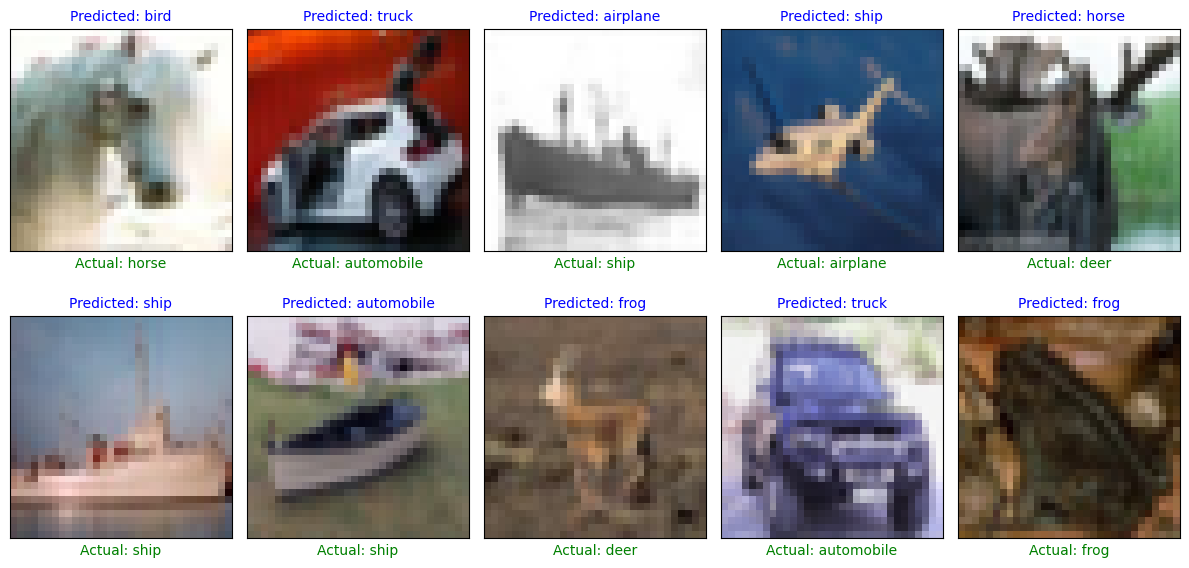

In [ ]:
# ---------------------------WRITE DOWN YOUR CODE HERE--------------------------
#
#
#
import matplotlib.pyplot as plt
import numpy as np
import torch

# Đặt seed để đảm bảo ngẫu nhiên hóa ảnh được tái lập
torch.manual_seed(42)
np.random.seed(42)

# Danh sách tên lớp của CIFAR-10
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

# Hiển thị 10 ảnh ngẫu nhiên với nhãn thực tế và dự đoán
def display_random_images_with_labels(model, dataloader, num_images=10):
    model.eval()
    images, labels = next(iter(dataloader))  # Lấy một batch ảnh
    selected_indices = np.random.choice(len(images), num_images, replace=False)  # Chọn ngẫu nhiên 10 ảnh trong batch

    plt.figure(figsize=(12, 6))
    with torch.no_grad():
        for idx, i in enumerate(selected_indices):
            image, label = images[i].unsqueeze(0).cuda(), labels[i].item()
            output = model(image)
            _, predicted = torch.max(output, 1)
            pred_label = predicted.item()

            # Hiển thị ảnh và tên nhãn
            img = images[i].cpu().numpy().transpose((1, 2, 0))
            img = (img * 0.5) + 0.5  # Đảo chuẩn hóa

            plt.subplot(2, 5, idx + 1)
            plt.imshow(img)
            plt.title(f"Predicted: {class_names[pred_label]}", fontsize=10, color='blue')
            plt.xlabel(f"Actual: {class_names[label]}", fontsize=10, color='green')
            plt.xticks([])
            plt.yticks([])

    plt.tight_layout()
    plt.show()

# Hiển thị 10 ảnh từ mô hình có self-supervised learning
display_random_images_with_labels(cifar10_classifier, cifar10_test_loader)


#
#
#---------------------------YOUR CODE END HERE----------------------------------

**Bước 8. Hiển thị thử nghiệm 10 ảnh phân loại từ CSDL CIFAR-10 với mô hình huấn luyện KHÔNG dùng self-supervised learning**

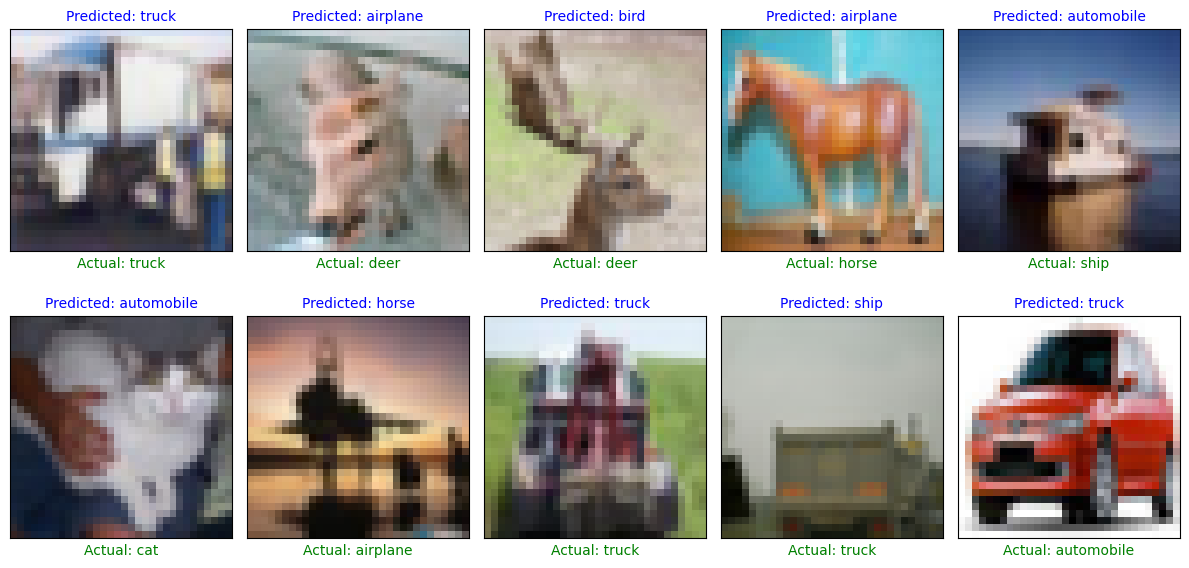

In [ ]:
# ---------------------------WRITE DOWN YOUR CODE HERE--------------------------
#
#
#
# Hiển thị 10 ảnh từ mô hình không qua self-supervised learning
display_random_images_with_labels(cifar10_classifier_scratch, cifar10_test_loader)
#
#
#---------------------------YOUR CODE END HERE----------------------------------